---
### K-Nearest Neighbours
---
Aim: produce a kNN model to identify gamma signals and separate them from the background hadron measurements. 

Data: Telescope dataset

Source: https://www.kaggle.com/brsdincer/telescope-spectrum-gamma-or-hadron

---
#### Data Dictionary
---

DATA FOR PREDICTION GAMMA OR HADRON

- fLength -- major axis of ellipse (mm)
- fWidth -- minor axis of ellipse (mm)
- fSize -- 10-log of sum of content of all pixels (in #phot)
- fConc -- ratio of sum of two highest pixels over fSize (ratio)
- fConc1 -- ratio of highest pixel over fSize (ratio)
- fAsym -- distance from highest pixel to center, projected onto major axis (mm)
- fM3Long -- 3rd root of third moment along major axis (mm)
- fM3Trans -- 3rd root of third moment along minor axis (mm)
- fAlpha -- angle of major axis with vector to origin (deg)
- fDist -- distance from origin to center of ellipse (mm)
- class -- gamma (signal), hadron (background)

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
sns.set()

---
#### Import & Inspect Data
---

In [2]:
data = pd.read_csv(r'telescope.csv') #, index_col = 0).rename(columns = {'TARGET CLASS':'Target'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [3]:
# Assign: Gamma = 1, Hadron = 0
target_assignments = {}
for i in enumerate(data['class']):
    if i[1] == 'g':
        j = 1
    elif i[1] == 'h':
        j = 0
    target_assignments.update({i[0]: j})
data['target'] = data.index.map(target_assignments)

---
#### Prepare Data
---

In [4]:
scaler = MinMaxScaler()
scaler.fit(data.drop(data.columns[-2:], axis = 1))

features = scaler.transform(data.drop(data.columns[-2:], axis = 1))
features_df = pd.DataFrame(features, columns = data.columns[:-2])
features_df.describe().round(3)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000,19020.000,19020.000,19020.000,19020.000,19020.000,19020.000,19020.000,19020.000,19020.000
mean,0.148,0.087,0.261,0.417,0.318,0.439,0.600,0.534,0.307,0.390
std,0.128,0.072,0.140,0.208,0.164,0.057,0.089,0.054,0.290,0.151
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.061,0.046,0.158,0.253,0.190,0.423,0.559,0.506,0.062,0.286
50%,0.100,0.067,0.236,0.388,0.291,0.447,0.609,0.535,0.196,0.386
75%,0.200,0.096,0.343,0.558,0.422,0.467,0.645,0.562,0.510,0.484
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


---
#### Build Model
---

In [5]:
x = features_df
y = data[data.columns[-1]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state = 33)
kNN = KNeighborsClassifier(n_neighbors = 1, leaf_size = 64, weights = 'uniform', algorithm = 'ball_tree')
kNN.fit(x_train, y_train)

y_pred = kNN.predict(x_test)

---
#### Model Optimisation
---

In [6]:
# Optimal Number of Neighbours
error_rate = []
test_range = range(1, int(round(len(y_test)/75, 0))) 

for i in test_range:
    kNN_test = KNeighborsClassifier(n_neighbors = i, leaf_size = 64, weights = 'uniform', algorithm = 'ball_tree')
    kNN_test.fit(x_train, y_train)
    y_pred_test = kNN_test.predict(x_test)
    error_rate.append(np.mean(y_pred_test != y_test))

error_dict = {}
for i in enumerate(error_rate):
    j = int(i[0])
    k = i[1]
    error_dict.update({j: k})
    
error_df = pd.DataFrame(error_dict.values(), index = error_dict.keys()).reset_index().rename(columns = {'index': 'Optimal k', 0:'Error'})
optimal_kNN = error_df[error_df['Error'] == np.min(error_df['Error'])]

Min error: 0.161
Optimal k-value:  7


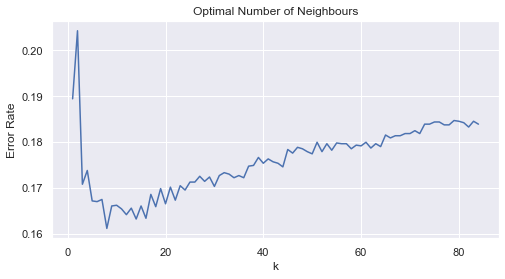

In [7]:
plt.figure(figsize = (8, 4))
plt.plot(test_range, error_rate)
plt.title('Optimal Number of Neighbours')
plt.xlabel('k')
plt.ylabel('Error Rate');

print('Min error:', optimal_kNN['Error'].values[0].round(3))
print('Optimal k-value: ', optimal_kNN['Optimal k'].values[0])


---
#### Re-run model with optimal k-value
---

In [8]:
kNN_optimal = KNeighborsClassifier(n_neighbors = optimal_kNN['Optimal k'].values[0])
kNN_optimal.fit(x_train, y_train)

y_pred_optimal = kNN_optimal.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred_optimal)
report = classification_report(y_test, y_pred_optimal) 

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      2230
           1       0.83      0.93      0.88      4110

    accuracy                           0.83      6340
   macro avg       0.84      0.79      0.80      6340
weighted avg       0.83      0.83      0.83      6340



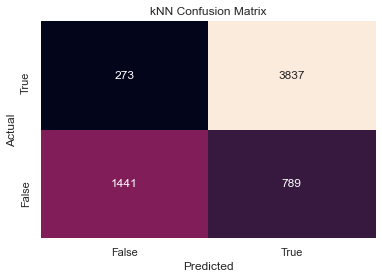

In [9]:
# Plot Output 
sns.heatmap(conf_matrix, annot = True, xticklabels = ['False', 'True'], 
            yticklabels = ['False', 'True'], cbar = False, fmt = 'g').invert_yaxis()
plt.title('kNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');
print(report)

In [10]:
x_final = data.iloc[:, :10]

scaler.fit(x_final)
x_features = scaler.transform(x_final)
x_features_df = pd.DataFrame(x_features, columns = x_final.columns)
features_df.describe().round(3)

pred_all = kNN_optimal.predict(x_features_df)

tele_type, f_class = {},{}
for i in enumerate(pred_all):
    if i[1] == 1:
        j = 'Gamma'
    elif i[1] == 0:
        j = 'Hadron'
    tele_type.update({i[0]: j})
    f_class.update({i[0]: i[1]})

Model accuracy:  85.7 %



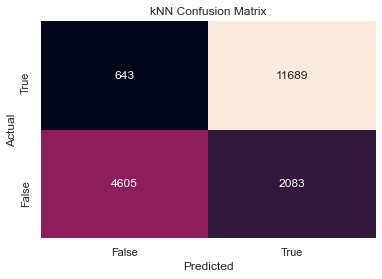

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      6688
           1       0.85      0.95      0.90     12332

    accuracy                           0.86     19020
   macro avg       0.86      0.82      0.83     19020
weighted avg       0.86      0.86      0.85     19020



In [11]:
data['kNN_pred'] = data.index.map(f_class)
data['kNN_type'] = data.index.map(tele_type)

accuracy_all = accuracy_score(data['target'], data['kNN_pred'])
conf_matrix2 = confusion_matrix(data['target'], data['kNN_pred'])
report2 = classification_report(data['target'], data['kNN_pred'])

sns.heatmap(conf_matrix2, annot = True, xticklabels = ['False', 'True'], 
            yticklabels = ['False', 'True'], cbar = False, fmt = 'g').invert_yaxis()

plt.title('kNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

print('Model accuracy: ', (100 * accuracy_all).round(1),'%\n')
plt.show()
print(report2)

The k-nearest neighbours algorithm has been implemented within this model. 

* The resulting application has a classification accuracy on the test set of 84%.
* The application on the whole dataset is simmilar at 85%.  
* The model has a bias towards false positives, around 10 - 15% of the test set was miss-classified this way, 
* False negatives make up only 3 - 5% of the reuslts.

Next step: Include oversampling of minority class to reduce misclassification.